<a href="https://colab.research.google.com/github/MaximKray21/CV_Projects/blob/main/Journey_to_Springfield.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import io
import os
from pathlib import Path
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!chmod 600 /content/kaggle.json
!cp kaggle.json ~/.kaggle/
!chmod 600 /content/kaggle.json

In [ ]:
!kaggle competitions download -c journey-springfield

 99% 516M/521M [00:03<00:00, 126MB/s]
100% 521M/521M [00:03<00:00, 156MB/s]


In [ ]:
!unzip './journey-springfield.zip'

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/simpsons_dataset/moe_szyslak/pic_1025.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1026.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1027.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1028.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1029.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1030.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1031.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1032.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1033.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1034.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1035.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1036.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1037.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1038.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pi

In [ ]:
p_train = Path('/content/train/simpsons_dataset')

In [ ]:
labels = sorted([class_.name for class_ in p_train.iterdir() if class_.is_dir()])

In [ ]:
train_files = sorted(list(p_train.glob('**/*.jpg')))

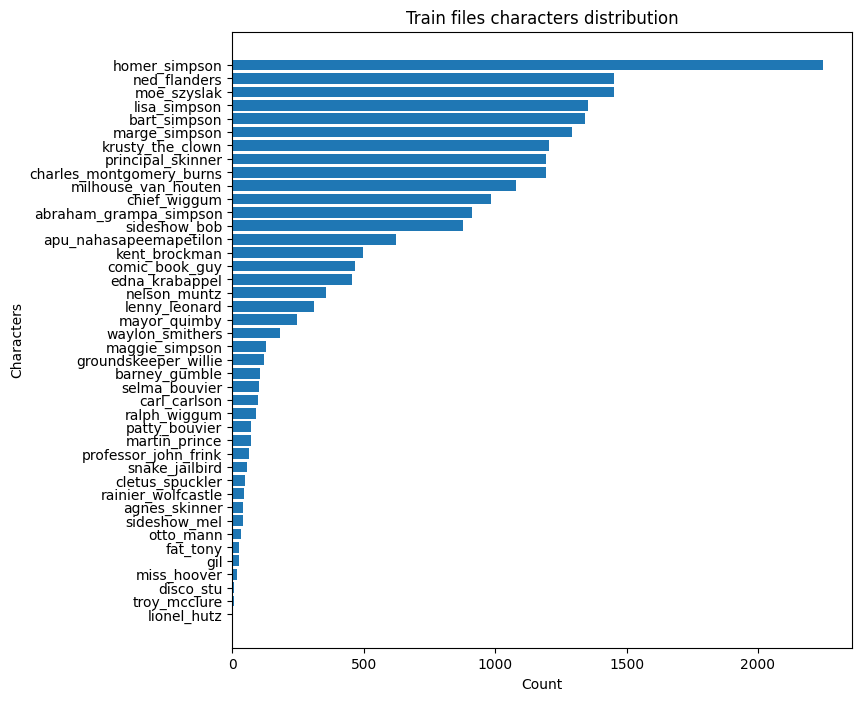

In [ ]:
import pandas as pd
counter = [path.parent.name for path in train_files]
counts = pd.Series(counter).value_counts()

plt.figure(figsize=(8,8))
plt.barh(counts.keys()[::-1], counts.sort_values(ascending=True))
plt.title('Train files characters distribution')
plt.xlabel('Count')
plt.ylabel('Characters')
plt.show();

In [ ]:
from torchvision import transforms as tfs
from sklearn.preprocessing import LabelEncoder
import pickle
from PIL import Image
import numpy as np

modes = ['train', 'test']

class simpsons_dataset(Dataset):
  def __init__(self, files, mode):
    self.files = files
    self.mode = mode
    self.len_ = len(self.files)
    self.label_encoder = LabelEncoder()

    if self.mode == 'train':
      self.labels = [path.parent.name for path in self.files]
      self.label_encoder.fit(self.labels)

      with open('le.pickle', 'wb') as dumped_file:
        pickle.dump(self.label_encoder, dumped_file)

  def __len__(self):
    return self.len_

  def load_img(self, file):
    img = Image.open(file)
    img.load()
    return img

  def __getitem__(self, indx):
    if self.mode == 'test':
      transform = tfs.Compose([
          tfs.Resize(size = (224, 224), antialias = True),
          tfs.Lambda(lambda x: np.array(x, dtype = 'float32') / 255),
          tfs.ToTensor(),
          tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])
    else:
      augmentation = tfs.RandomChoice([
          tfs.Compose([
              tfs.Resize(size = 300, max_size = 301),
              tfs.CenterCrop(300),
              tfs.RandomCrop(250)
          ]),
          tfs.RandomRotation((-25, 25)),
          tfs.RandomHorizontalFlip(p=1)
          ])
      transform = tfs.Compose([
          augmentation,
          tfs.Resize(size = (224, 224), antialias=True),
          tfs.Lambda(lambda x: np.array(x, dtype = 'float32') / 255),
          tfs.ToTensor(),
          tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])

    file = self.files[indx]
    x = self.load_img(file)
    x = transform(x)

    if self.mode == 'test':
      return x
    else:
      label = self.labels[indx]
      label_id = self.label_encoder.transform([label])
      y = label_id.item()
      return x, y

In [ ]:
len(train_files)

20933

In [ ]:
p_test = Path('/content/testset/testset')
test_files = sorted(list(p_test.glob('*.jpg')))

In [ ]:
train_files[:3]

[PosixPath('/content/train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg'),
 PosixPath('/content/train/simpsons_dataset/abraham_grampa_simpson/pic_0001.jpg'),
 PosixPath('/content/train/simpsons_dataset/abraham_grampa_simpson/pic_0002.jpg')]

In [ ]:
test_files[:3]

[PosixPath('/content/testset/testset/img0.jpg'),
 PosixPath('/content/testset/testset/img1.jpg'),
 PosixPath('/content/testset/testset/img10.jpg')]

In [ ]:
train_dataset = simpsons_dataset(train_files, mode = 'train')
test_dataset = simpsons_dataset(test_files, mode = 'test')

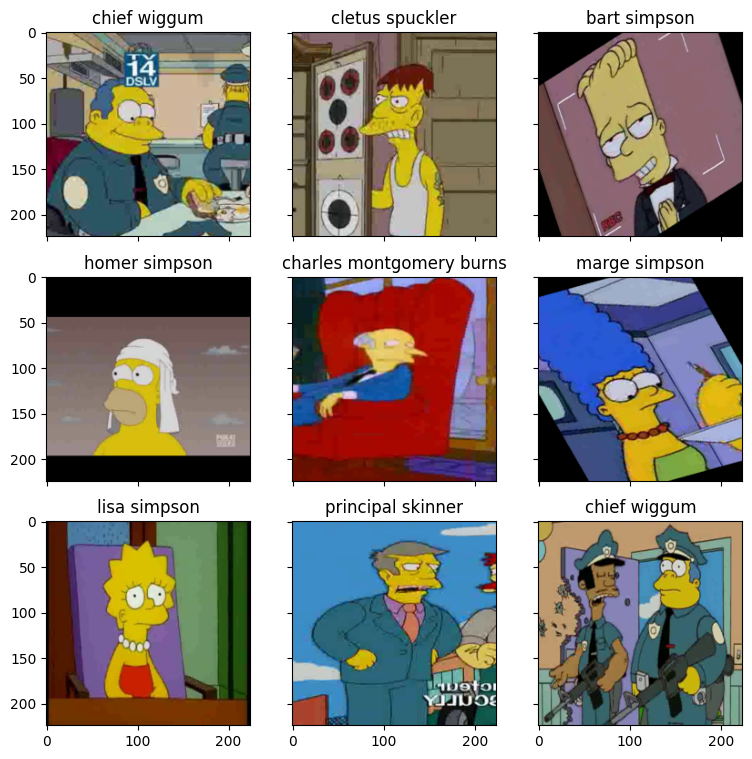

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

fig, ax = plt.subplots(figsize = (9, 9), sharey = True, sharex = True,
                       nrows = 3, ncols = 3)

for figx in ax.ravel():
  random_chr = np.array(np.random.uniform(20000), dtype = 'int').item()
  img, label = train_dataset[random_chr]
  img = img.permute(1,2,0)
  img = img * std + mean
  img = np.clip(img, 0, 1)
  figx.set_title(' '.join(train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
  figx.imshow(img)

Мы видим, что количество изображений по персонажам из Симпсонов в тренировочном датасете распределны неравномерно, потребуется аугментация данных, для нее будем использовать WeightedRandomSampler из PyTorch

In [ ]:
from tqdm import tqdm
count_weights = {k : 1/v for k, v in counts.items()}
sample_weights = train_dataset.__len__() * [0]

for i, (data, label) in enumerate(tqdm(train_dataset)):
  label_weight = count_weights[train_dataset.label_encoder.inverse_transform([label])[0]]
  sample_weights[i] = label_weight

100%|██████████| 20933/20933 [01:54<00:00, 182.43it/s]


In [ ]:
from torch.utils.data import WeightedRandomSampler
N = counts.max() * len(counts)
train_sampler = WeightedRandomSampler(sample_weights, num_samples = int(N),
                                      replacement=True)
batch_size = 10;
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, sampler = train_sampler)

In [ ]:
# from collections import Counter
# count = Counter()
# for data, labels in tqdm(train_dataloader):
#     count += Counter(labels.tolist())

# print(count)

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from tqdm import tqdm_notebook

def fit_epoch(model, train_dataloader, criterion, optimizer, scheduler):
  running_loss = 0; running_corrects = 0; running_data = 0

  for x, y in tqdm_notebook(train_dataloader):
    x = x.to(device); y = y.to(device)

    optimizer.zero_grad();

    out = model(x);
    loss = criterion(out, y)
    running_loss += loss.item() * y.size(0)
    loss.backward()
    optimizer.step()
    preds = out.argmax(-1)
    running_corrects += (preds == y).sum()
    running_data += y.size(0)

  scheduler.step()
  train_acc = running_corrects / running_data
  train_loss = running_loss / running_data

  return train_loss, train_acc

In [ ]:
def train(model, epochs, batch_size, train_dataloader):
  history = {'loss' : [], 'acc' : []}

  log_template = 'Epoch - {ep: 03d}, train loss: {tr_loss: 0.4f}, train acc: {tr_acc: 0.4f}'

  with tqdm(desc = 'Epoch', total = epochs) as pbar:
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= epochs // 4, gamma=0.1)

    for epoch in range(epochs):
      train_loss, train_acc = fit_epoch(model, train_dataloader, criterion, optimizer, scheduler)

      history['loss'].append(train_loss)
      history['acc'].append(train_acc)

      pbar.update(1)
      tqdm.write(log_template.format(ep=epoch+1, tr_loss = train_loss, tr_acc = train_acc))
  return history

In [ ]:
from torch import nn as nn
class SimpleCNN(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=2400, out_features=4800),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4800, out_features=4800),
            nn.ReLU(),
        )

        self.fc3 = nn.Sequential(
            nn.Linear(in_features=4800, out_features=self.n_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
model = SimpleCNN(len(np.unique(train_dataset.labels)))
model = model.to(device)

history = train(model, epochs = 20, batch_size = batch_size, train_dataloader = train_dataloader)

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/Colab Notebooks/kaggle/Face Recognition/weights_of_model')

In [ ]:
fig, ax = plt.subplots(figsize = (9, 9), sharey = True, sharex = True,
                       nrows = 2, ncols = 1)

metrics = list(history.keys())
for i, figx in enumerate(ax.ravel()):
  figx.set_title(f'History of metrics {metrics[i]}')
  figx.set_xlabel('epoch')
  figx.set_ylabel(metrics[i])
  figx.plot(history[metrics[i]])